In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import csv


##Define  Classes for Batchnorm and GhostBatchNorm

In [0]:
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super().__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias

In [0]:
class GhostBatchNorm(BatchNorm):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        print('GhostBatchNorm CLASS',num_splits)
        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):  # lazily collate stats when we are going to use them
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(
                self.num_splits)
        return super().train(mode)

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C * self.num_splits, H, W), self.running_mean, self.running_var,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features],
                self.weight, self.bias, False, self.momentum, self.eps)

In [0]:
def norm2d(output_channels, BatchNorm='BN'):
    print("output_channels:{}".format(output_channels))
    if BatchNorm=='GBN':
        num_splits = 2 #128 // 32
        print(" Currently using Ghost Normalization ")
        print("GHOST NORM output_channels",output_channels)
        return GhostBatchNorm(output_channels,num_splits)
    else:
        return nn.BatchNorm2d(output_channels)

##Create NN Class and specify the required Layers. The Class takes Batchnorm Type as Parameter. There are two possible values, GBN or BN. By default class is intantiated with BN = Batch Normalization

In [0]:
class Net(nn.Module):
    def __init__(self,BatchNorm="BN"):
        super(Net, self).__init__()
        
        do_value=0.05
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=20, kernel_size=(3,3), padding=0, stride=1), 
            #nn.BatchNorm2d(20),
            norm2d(20,BatchNorm),
            nn.Dropout(do_value),
            nn.ReLU()
        )
        #Output=26 RF=3X3 [RFin + (Ksize-1 * JMPin) => 1+(3-1)*1 =3]  :JMPin=1, Jout= JMPin X s = 1
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(3,3), padding=0, stride=1),
            #nn.BatchNorm2d(16),
            norm2d(16,BatchNorm),
            nn.Dropout(do_value),
            nn.ReLU()    
        )
        #Output=24 RF=5X5  [RFin + (Ksize-1 * JMPin) => 3+(3-1)*1 =5] :JMPin=1, Jout =JMPin X s =1

        self.pool1 = nn.MaxPool2d(2, 2)#Output=12 RF=6X6 [RFin + (Ksize-1 * JMPin) => 5+(2-1)*1 =6] :JMPin=1, Jout=  JMPin X s =2

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, stride=1),
            #nn.BatchNorm2d(16),
            norm2d(16,BatchNorm),
            nn.Dropout(do_value),
            nn.ReLU()
        )
        #Output=10 RF=10X10 [RFin + (Ksize-1 * JMPin) => 6+(3-1)*2 =10] : Jout= JMPin X s = 2X1 :JMPin=2, Jout= JMPin X s = 2X1=2

        self.pool2 = nn.MaxPool2d(2, 2) #Output=5 RF=12[RFin + (Ksize-1 * JMPin) => 10+(2-1)*2 =12]  :JMPin=2, Jout =JMPin X s = 2X2 =4

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, stride=1),
            #nn.BatchNorm2d(16),
            norm2d(16,BatchNorm),
            nn.Dropout(do_value),
            nn.ReLU()            
        )
        #Output=3 RF= 20[RFin + (Ksize-1 * JMPin) => 12+(3-1)*4 =20] :JMPin=4, Jout =JMPin X s = 4X1=4
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=13, kernel_size=(3,3), padding=0, stride=1),
            #nn.BatchNorm2d(13),
            norm2d(13,BatchNorm),
            nn.Dropout(do_value),
            nn.ReLU()
            
        )
        #Output=1 RF=28 [RFin + (Ksize-1 * JMPin) => 20+(3-1)*4 =28]  :JMPin=4, Jout=JMPin X s = 4X1=4
        
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=13, out_channels=10, kernel_size=(1,1), padding=0, stride=1)
            
        )
        
     

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.pool2(x)
        x = self.conv4(x)
        x = self.conv5(x)   
        x = self.conv6(x)      
        x = x.view(-1, 10)
        return F.log_softmax(x)

##Below, Train and Test Functions are created. The Test function spits out/retuens the list of Images falsly classified.

##Additionally The Train and Test functions's Loss and Accuracies are stored in below declared Lists. These lists shall be used to generate graph.

In [0]:
Total_train_loss_BN_NONE=[]
Total_train_loss_BN_L1=[]
Total_train_loss_BN_L2=[]
Total_train_loss_BN_L1L2=[]
Total_train_loss_GBN_NONE=[]
Total_train_loss_GBN_L1=[]
Total_train_loss_GBN_L2=[]
Total_train_loss_GBN_L1L2=[]

Validation_Accuracy_BN_NONE=[]
Validation_Accuracy_BN_L1=[]
Validation_Accuracy_BN_L2=[]
Validation_Accuracy_BN_L1L2=[]
Validation_Accuracy_GBN_NONE=[]
Validation_Accuracy_GBN_L1=[]
Validation_Accuracy_GBN_L2=[]
Validation_Accuracy_GBN_L1L2=[]


Total_Test_loss_BN_NONE=[]
Total_Test_loss_BN_L1=[]
Total_Test_loss_BN_L2=[]
Total_Test_loss_BN_L1L2=[]
Total_Test_loss_GBN_NONE=[]
Total_Test_loss_GBN_L1=[]
Total_Test_loss_GBN_L2=[]
Total_Test_loss_GBN_L1L2=[]

def train(model, device, train_loader, optimizer,epoch,Regularization,Regularization_type,BNType):
    
    model.train()
    pbar = tqdm(train_loader)
    correct_train=0
    processed=0
    Regularization=0
    total_train_loss=0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)

        if Regularization_type =='L1' or Regularization_type =='L1L2':
            reg_loss=0
            factor = 0.0005  
            l1_crit =nn.L1Loss(size_average=False)
            for param in model.parameters():
                target_vec = torch.zeros_like(param)
                reg_loss += l1_crit(param,target_vec)
                reg_loss = reg_loss / (batch_idx + 1)
                Regularization=factor * reg_loss
        loss +=Regularization
        total_train_loss += loss.item()

        pred = output.argmax(dim=1, keepdim=True)
        correct_train += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        #Train_Accuracy.append(100.00 *correct_train/processed)
        loss.backward()#(retain_graph=True)
        optimizer.step()

        optimizer.zero_grad() #Added because of error
        pbar.set_description(desc= f'TRAINING Loss={loss.item()} batch_id={batch_idx} TRAIN ACCURACY={100.00 *correct_train/processed:0.02f}')
    total_train_loss=total_train_loss/(batch_idx+1)
        
        ##Added detailed percentage:

    if BNType=="BN" and Regularization_type =='None':
        Total_train_loss_BN_NONE.append(total_train_loss)
    elif BNType=="BN" and Regularization_type =='L1':
        Total_train_loss_BN_L1.append(total_train_loss)
    elif BNType=="BN" and Regularization_type =='L2':
        Total_train_loss_BN_L2.append(total_train_loss)
    elif BNType=="BN" and Regularization_type =='L1L2':
        Total_train_loss_BN_L1L2.append(total_train_loss)
    elif BNType=="GBN" and Regularization_type =='None':
        Total_train_loss_GBN_NONE.append(total_train_loss)
    elif BNType=="GBN" and Regularization_type =='L1':
        Total_train_loss_GBN_L1.append(total_train_loss)
    elif BNType=="GBN" and Regularization_type =='L2':
        Total_train_loss_GBN_L2.append(total_train_loss)
    elif BNType=="GBN" and Regularization_type =='L1L2':
        Total_train_loss_GBN_L1L2.append(total_train_loss)

        #pbar.set_description(desc= f'TRAIN Loss={loss.item()} batch_id={batch_idx} Correct={correct_train} / {len(train_loader.dataset)} TRAIN ACCURACY={100.00 *correct_train/processed:0.02f}')

def test(model, device, test_loader,BNType,Regularization_type):
    model.eval()
    test_loss = 0
    correct = 0
    preds=([])
    actuals=([])
    total_false=0
    false_images=[]
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss=F.nll_loss(output, target)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss       
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability           
            
            # To capture misclassification
            target_image = target.view_as(pred)
            for i in range(len(pred)):
              if pred[i].item()!= target_image[i].item():
                 false_images.append([data[i], pred[i], target_image[i]])
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    #Total_Test_loss.append(test_loss)

    print("Number of Misclassifed Images = ",len(false_images))

    if BNType=="BN" and Regularization_type =='None':
        Total_Test_loss_BN_NONE.append(test_loss)
        Validation_Accuracy_BN_NONE.append(100. * correct / len(test_loader.dataset))

    elif BNType=="BN" and Regularization_type =='L1':
        Total_Test_loss_BN_L1.append(test_loss)
        Validation_Accuracy_BN_L1.append(100. * correct / len(test_loader.dataset))
    elif BNType=="BN" and Regularization_type =='L2':
        Total_Test_loss_BN_L2.append(test_loss)
        Validation_Accuracy_BN_L2.append(100. * correct / len(test_loader.dataset))
    elif BNType=="BN" and Regularization_type =='L1L2':
        Total_Test_loss_BN_L1L2.append(test_loss)
        Validation_Accuracy_BN_L1L2.append(100. * correct / len(test_loader.dataset))
    elif BNType=="GBN" and Regularization_type =='None':
        Total_Test_loss_GBN_NONE.append(test_loss)
        Validation_Accuracy_GBN_NONE.append(100. * correct / len(test_loader.dataset))

    elif BNType=="GBN" and Regularization_type =='L1':
        Total_Test_loss_GBN_L1.append(test_loss)
        Validation_Accuracy_GBN_L1.append(100. * correct / len(test_loader.dataset))
    elif BNType=="GBN" and Regularization_type =='L2':
        Total_Test_loss_GBN_L2.append(test_loss)
        Validation_Accuracy_GBN_L2.append(100. * correct / len(test_loader.dataset))
    elif BNType=="GBN" and Regularization_type =='L1L2':
        Total_Test_loss_GBN_L1L2.append(test_loss)
        Validation_Accuracy_GBN_L1L2.append(100. * correct / len(test_loader.dataset))
    #Test_Accuracy.append(100. * correct / len(test_loader.dataset))
    print('\nTEST: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return false_images
    


## exec_Models Function: This  Function will be called by Main Iterator to execute/call Models for 8 different combination of Regualarization and Batch normalization

In [0]:
def exec_Models(model,Regularization_type,  EPOCHS,BNType, train_loader,test_loader):
  Regularization=0
  weight_decay=0
  preds_BN=([])
  actuals_BN=([])
  preds_GBN=([])
  actuals_GBN=([])
  false_images_BN=[]
  false_images_GBN=[]
  if Regularization_type == 'None':
      Regularization=0
      weight_decay= 0
  elif Regularization_type == 'L1':
     weight_decay= 0
  elif Regularization_type == 'L2':
       weight_decay= 0.01
  elif Regularization_type == 'L1L2':
      weight_decay= 0.01

  print('Regularization??',Regularization)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=weight_decay)
  scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
  
  for epoch in range(EPOCHS):
      print('EPOCH #',epoch)
      print('weight_decay',weight_decay)
      print('Regularization_type',Regularization_type )
      print('BNType',BNType )
      train(model, device, train_loader,optimizer, epoch,Regularization,Regularization_type,BNType) 
      false_images=test(model, device, test_loader,BNType,Regularization_type)
      print('----------------------------------------------------------------------')
  if Regularization_type=='None':
    if BNType=='BN':
        false_images_BN =false_images
    elif BNType=='GBN':
        false_images_GBN =false_images
  
  return false_images_BN,false_images_GBN


## Load_data: Function to load data from Dataset, and split into Train/Test, normalize and also Batch size is defined here

In [0]:
def Load_data(batch_size):
  torch.manual_seed(1)
  batch_size = batch_size
  use_cuda = torch.cuda.is_available()
  kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
  train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  return train_loader,test_loader

##Iterate through the two Options, With BN and With GBN and call the model for all 4 options - with/without L1,L2, with L1, with L2

In [10]:
from torch.optim.lr_scheduler import StepLR
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
#model = Net(BatchNorm="GBN").to(device)
Misclassfication_false_images_BN = []
Misclassfication_false_images_GBN = []

EPOCHS=25

Regularization_List=['None','L1','L2','L1L2']
BatchNorm_List=['GBN','BN']
for bnType_method in BatchNorm_List:
  print(bnType_method)
  if bnType_method =='BN':
      train_loader,test_loader=Load_data(64)
  else:
       train_loader,test_loader=Load_data(128)
  for Reg_method in Regularization_List:
      print('Regualarization method',Reg_method)
      print('BATCH NORMALIZATION TYPE?',bnType_method)
      model = Net(bnType_method).to(device)
      model.eval()
      summary(model, input_size=(1, 28, 28))
      Misclassfication_false_images_BN,Misclassfication_false_images_GBN=exec_Models(model,Reg_method,  EPOCHS,bnType_method, train_loader,test_loader)

plot_Misclassified_Images(Misclassfication_false_images_BN) # BN without L1/L2
plot_Misclassified_Images(Misclassfication_false_images_GBN) # GBN without L1/L2



GBN


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!
Regualarization method None
BATCH NORMALIZATION TYPE? GBN
output_channels:20
 Currently using Ghost Normalization 
GHOST NORM output_channels 20
GhostBatchNorm CLASS 2


output_channels:16
 Currently using Ghost Normalization 
GHOST NORM output_channels 16
GhostBatchNorm CLASS 2
output_channels:16
 Currently using Ghost Normalization 
GHOST NORM output_channels 16
GhostBatchNorm CLASS 2
output_channels:16
 Currently using Ghost Normalization 
GHOST NORM output_channels 16
GhostBatchNorm CLASS 2
output_channels:13
 Currently using Ghost Normalization 
GHOST NORM output_channels 13
GhostBatchNorm CLASS 2


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:73: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  0%|          | 0/469 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 26, 26]             200
    GhostBatchNorm-2           [-1, 20, 26, 26]              40
           Dropout-3           [-1, 20, 26, 26]               0
              ReLU-4           [-1, 20, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,896
    GhostBatchNorm-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
              ReLU-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           2,320
   GhostBatchNorm-11           [-1, 16, 10, 10]              32
          Dropout-12           [-1, 16, 10, 10]               0
             ReLU-13           [-1, 16, 10, 10]               0
        MaxPool2d-14             [-1, 1

TRAINING Loss=0.0766693502664566 batch_id=468 TRAIN ACCURACY=88.23: 100%|██████████| 469/469 [00:11<00:00, 39.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  211

TEST: Average loss: 0.0858, Accuracy: 9789/10000 (97.89%)

----------------------------------------------------------------------
EPOCH # 1
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.08655592054128647 batch_id=468 TRAIN ACCURACY=96.92: 100%|██████████| 469/469 [00:11<00:00, 39.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  123

TEST: Average loss: 0.0445, Accuracy: 9877/10000 (98.77%)

----------------------------------------------------------------------
EPOCH # 2
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.08219496160745621 batch_id=468 TRAIN ACCURACY=97.58: 100%|██████████| 469/469 [00:11<00:00, 39.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  114

TEST: Average loss: 0.0386, Accuracy: 9886/10000 (98.86%)

----------------------------------------------------------------------
EPOCH # 3
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.032823625952005386 batch_id=468 TRAIN ACCURACY=98.00: 100%|██████████| 469/469 [00:11<00:00, 40.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  109

TEST: Average loss: 0.0364, Accuracy: 9891/10000 (98.91%)

----------------------------------------------------------------------
EPOCH # 4
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.06147756054997444 batch_id=468 TRAIN ACCURACY=98.26: 100%|██████████| 469/469 [00:11<00:00, 40.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  97

TEST: Average loss: 0.0315, Accuracy: 9903/10000 (99.03%)

----------------------------------------------------------------------
EPOCH # 5
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.09297188371419907 batch_id=468 TRAIN ACCURACY=98.30: 100%|██████████| 469/469 [00:11<00:00, 40.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  89

TEST: Average loss: 0.0289, Accuracy: 9911/10000 (99.11%)

----------------------------------------------------------------------
EPOCH # 6
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.1321040540933609 batch_id=468 TRAIN ACCURACY=98.39: 100%|██████████| 469/469 [00:11<00:00, 40.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  98

TEST: Average loss: 0.0306, Accuracy: 9902/10000 (99.02%)

----------------------------------------------------------------------
EPOCH # 7
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.025516854599118233 batch_id=468 TRAIN ACCURACY=98.52: 100%|██████████| 469/469 [00:11<00:00, 40.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  94

TEST: Average loss: 0.0292, Accuracy: 9906/10000 (99.06%)

----------------------------------------------------------------------
EPOCH # 8
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.07642812281847 batch_id=468 TRAIN ACCURACY=98.64: 100%|██████████| 469/469 [00:11<00:00, 40.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  93

TEST: Average loss: 0.0279, Accuracy: 9907/10000 (99.07%)

----------------------------------------------------------------------
EPOCH # 9
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.04447803273797035 batch_id=468 TRAIN ACCURACY=98.69: 100%|██████████| 469/469 [00:11<00:00, 41.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  91

TEST: Average loss: 0.0292, Accuracy: 9909/10000 (99.09%)

----------------------------------------------------------------------
EPOCH # 10
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.015422915108501911 batch_id=468 TRAIN ACCURACY=98.77: 100%|██████████| 469/469 [00:11<00:00, 41.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  71

TEST: Average loss: 0.0247, Accuracy: 9929/10000 (99.29%)

----------------------------------------------------------------------
EPOCH # 11
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.031511370092630386 batch_id=468 TRAIN ACCURACY=98.73: 100%|██████████| 469/469 [00:11<00:00, 41.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  99

TEST: Average loss: 0.0279, Accuracy: 9901/10000 (99.01%)

----------------------------------------------------------------------
EPOCH # 12
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.024074723944067955 batch_id=468 TRAIN ACCURACY=98.86: 100%|██████████| 469/469 [00:11<00:00, 40.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  77

TEST: Average loss: 0.0246, Accuracy: 9923/10000 (99.23%)

----------------------------------------------------------------------
EPOCH # 13
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.026059413328766823 batch_id=468 TRAIN ACCURACY=98.89: 100%|██████████| 469/469 [00:11<00:00, 40.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  87

TEST: Average loss: 0.0275, Accuracy: 9913/10000 (99.13%)

----------------------------------------------------------------------
EPOCH # 14
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.007231593132019043 batch_id=468 TRAIN ACCURACY=98.89: 100%|██████████| 469/469 [00:11<00:00, 40.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  75

TEST: Average loss: 0.0263, Accuracy: 9925/10000 (99.25%)

----------------------------------------------------------------------
EPOCH # 15
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.05159891024231911 batch_id=468 TRAIN ACCURACY=98.96: 100%|██████████| 469/469 [00:11<00:00, 40.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  78

TEST: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

----------------------------------------------------------------------
EPOCH # 16
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.0025555789470672607 batch_id=468 TRAIN ACCURACY=98.95: 100%|██████████| 469/469 [00:11<00:00, 39.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  74

TEST: Average loss: 0.0233, Accuracy: 9926/10000 (99.26%)

----------------------------------------------------------------------
EPOCH # 17
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.0056205689907073975 batch_id=468 TRAIN ACCURACY=98.99: 100%|██████████| 469/469 [00:11<00:00, 40.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  77

TEST: Average loss: 0.0255, Accuracy: 9923/10000 (99.23%)

----------------------------------------------------------------------
EPOCH # 18
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.03516434133052826 batch_id=468 TRAIN ACCURACY=99.04: 100%|██████████| 469/469 [00:11<00:00, 40.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  78

TEST: Average loss: 0.0231, Accuracy: 9922/10000 (99.22%)

----------------------------------------------------------------------
EPOCH # 19
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.0069742947816848755 batch_id=468 TRAIN ACCURACY=98.96: 100%|██████████| 469/469 [00:11<00:00, 40.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  73

TEST: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)

----------------------------------------------------------------------
EPOCH # 20
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.022476861253380775 batch_id=468 TRAIN ACCURACY=99.02: 100%|██████████| 469/469 [00:11<00:00, 40.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  68

TEST: Average loss: 0.0217, Accuracy: 9932/10000 (99.32%)

----------------------------------------------------------------------
EPOCH # 21
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.012420624494552612 batch_id=468 TRAIN ACCURACY=99.03: 100%|██████████| 469/469 [00:11<00:00, 41.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  74

TEST: Average loss: 0.0249, Accuracy: 9926/10000 (99.26%)

----------------------------------------------------------------------
EPOCH # 22
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.091688372194767 batch_id=468 TRAIN ACCURACY=99.11: 100%|██████████| 469/469 [00:11<00:00, 39.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  66

TEST: Average loss: 0.0220, Accuracy: 9934/10000 (99.34%)

----------------------------------------------------------------------
EPOCH # 23
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.023226052522659302 batch_id=468 TRAIN ACCURACY=99.15: 100%|██████████| 469/469 [00:11<00:00, 40.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  70

TEST: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

----------------------------------------------------------------------
EPOCH # 24
weight_decay 0
Regularization_type None
BNType GBN


TRAINING Loss=0.009498466737568378 batch_id=468 TRAIN ACCURACY=99.14: 100%|██████████| 469/469 [00:11<00:00, 39.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  71

TEST: Average loss: 0.0205, Accuracy: 9929/10000 (99.29%)

----------------------------------------------------------------------
Regualarization method L1
BATCH NORMALIZATION TYPE? GBN
output_channels:20
 Currently using Ghost Normalization 
GHOST NORM output_channels 20
GhostBatchNorm CLASS 2
output_channels:16
 Currently using Ghost Normalization 
GHOST NORM output_channels 16
GhostBatchNorm CLASS 2
output_channels:16
 Currently using Ghost Normalization 
GHOST NORM output_channels 16
GhostBatchNorm CLASS 2
output_channels:16
 Currently using Ghost Normalization 
GHOST NORM output_channels 16
GhostBatchNorm CLASS 2
output_channels:13
 Currently using Ghost Normalization 
GHOST NORM output_channels 13
GhostBatchNorm CLASS 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 26, 26]             200
    GhostBatchNorm-2           [-1

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
TRAINING Loss=0.13177582621574402 batch_id=468 TRAIN ACCURACY=89.88: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  159

TEST: Average loss: 0.0669, Accuracy: 9841/10000 (98.41%)

----------------------------------------------------------------------
EPOCH # 1
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.0738397017121315 batch_id=468 TRAIN ACCURACY=96.91: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  123

TEST: Average loss: 0.0446, Accuracy: 9877/10000 (98.77%)

----------------------------------------------------------------------
EPOCH # 2
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.15436452627182007 batch_id=468 TRAIN ACCURACY=97.82: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  97

TEST: Average loss: 0.0336, Accuracy: 9903/10000 (99.03%)

----------------------------------------------------------------------
EPOCH # 3
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.014084983617067337 batch_id=468 TRAIN ACCURACY=98.08: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  88

TEST: Average loss: 0.0281, Accuracy: 9912/10000 (99.12%)

----------------------------------------------------------------------
EPOCH # 4
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.06782558560371399 batch_id=468 TRAIN ACCURACY=98.28: 100%|██████████| 469/469 [00:13<00:00, 34.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  79

TEST: Average loss: 0.0276, Accuracy: 9921/10000 (99.21%)

----------------------------------------------------------------------
EPOCH # 5
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.02423318289220333 batch_id=468 TRAIN ACCURACY=98.31: 100%|██████████| 469/469 [00:13<00:00, 33.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  73

TEST: Average loss: 0.0246, Accuracy: 9927/10000 (99.27%)

----------------------------------------------------------------------
EPOCH # 6
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.039251212030649185 batch_id=468 TRAIN ACCURACY=98.44: 100%|██████████| 469/469 [00:13<00:00, 34.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  93

TEST: Average loss: 0.0313, Accuracy: 9907/10000 (99.07%)

----------------------------------------------------------------------
EPOCH # 7
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.05190885812044144 batch_id=468 TRAIN ACCURACY=98.55: 100%|██████████| 469/469 [00:13<00:00, 34.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  61

TEST: Average loss: 0.0238, Accuracy: 9939/10000 (99.39%)

----------------------------------------------------------------------
EPOCH # 8
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.03234227001667023 batch_id=468 TRAIN ACCURACY=98.69: 100%|██████████| 469/469 [00:13<00:00, 33.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  71

TEST: Average loss: 0.0242, Accuracy: 9929/10000 (99.29%)

----------------------------------------------------------------------
EPOCH # 9
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.03213895857334137 batch_id=468 TRAIN ACCURACY=98.73: 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  66

TEST: Average loss: 0.0248, Accuracy: 9934/10000 (99.34%)

----------------------------------------------------------------------
EPOCH # 10
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.06578736007213593 batch_id=468 TRAIN ACCURACY=98.82: 100%|██████████| 469/469 [00:13<00:00, 34.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  69

TEST: Average loss: 0.0235, Accuracy: 9931/10000 (99.31%)

----------------------------------------------------------------------
EPOCH # 11
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.019468994811177254 batch_id=468 TRAIN ACCURACY=98.84: 100%|██████████| 469/469 [00:14<00:00, 33.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  66

TEST: Average loss: 0.0238, Accuracy: 9934/10000 (99.34%)

----------------------------------------------------------------------
EPOCH # 12
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.02075526863336563 batch_id=468 TRAIN ACCURACY=98.84: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  66

TEST: Average loss: 0.0228, Accuracy: 9934/10000 (99.34%)

----------------------------------------------------------------------
EPOCH # 13
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.08642865717411041 batch_id=468 TRAIN ACCURACY=98.83: 100%|██████████| 469/469 [00:13<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  74

TEST: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

----------------------------------------------------------------------
EPOCH # 14
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.0400918647646904 batch_id=468 TRAIN ACCURACY=98.92: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  68

TEST: Average loss: 0.0237, Accuracy: 9932/10000 (99.32%)

----------------------------------------------------------------------
EPOCH # 15
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.010048226453363895 batch_id=468 TRAIN ACCURACY=99.05: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  69

TEST: Average loss: 0.0230, Accuracy: 9931/10000 (99.31%)

----------------------------------------------------------------------
EPOCH # 16
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.028436841443181038 batch_id=468 TRAIN ACCURACY=98.95: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  68

TEST: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

----------------------------------------------------------------------
EPOCH # 17
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.02691715583205223 batch_id=468 TRAIN ACCURACY=98.98: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  60

TEST: Average loss: 0.0200, Accuracy: 9940/10000 (99.40%)

----------------------------------------------------------------------
EPOCH # 18
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.007034310605376959 batch_id=468 TRAIN ACCURACY=99.00: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  65

TEST: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

----------------------------------------------------------------------
EPOCH # 19
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.08553626388311386 batch_id=468 TRAIN ACCURACY=99.02: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  61

TEST: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)

----------------------------------------------------------------------
EPOCH # 20
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.0019069061381742358 batch_id=468 TRAIN ACCURACY=99.12: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  57

TEST: Average loss: 0.0202, Accuracy: 9943/10000 (99.43%)

----------------------------------------------------------------------
EPOCH # 21
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.01322863344103098 batch_id=468 TRAIN ACCURACY=99.09: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  61

TEST: Average loss: 0.0209, Accuracy: 9939/10000 (99.39%)

----------------------------------------------------------------------
EPOCH # 22
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.021494120359420776 batch_id=468 TRAIN ACCURACY=99.08: 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  68

TEST: Average loss: 0.0223, Accuracy: 9932/10000 (99.32%)

----------------------------------------------------------------------
EPOCH # 23
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.10663356631994247 batch_id=468 TRAIN ACCURACY=99.17: 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  63

TEST: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)

----------------------------------------------------------------------
EPOCH # 24
weight_decay 0
Regularization_type L1
BNType GBN


TRAINING Loss=0.06984157860279083 batch_id=468 TRAIN ACCURACY=99.10: 100%|██████████| 469/469 [00:14<00:00, 32.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  69

TEST: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

----------------------------------------------------------------------
Regualarization method L2
BATCH NORMALIZATION TYPE? GBN
output_channels:20
 Currently using Ghost Normalization 
GHOST NORM output_channels 20
GhostBatchNorm CLASS 2
output_channels:16
 Currently using Ghost Normalization 
GHOST NORM output_channels 16
GhostBatchNorm CLASS 2
output_channels:16
 Currently using Ghost Normalization 
GHOST NORM output_channels 16
GhostBatchNorm CLASS 2
output_channels:16
 Currently using Ghost Normalization 
GHOST NORM output_channels 16
GhostBatchNorm CLASS 2
output_channels:13
 Currently using Ghost Normalization 
GHOST NORM output_channels 13
GhostBatchNorm CLASS 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 26, 26]             200
    GhostBatchNorm-2           [-1

TRAINING Loss=0.19130589067935944 batch_id=468 TRAIN ACCURACY=88.45: 100%|██████████| 469/469 [00:12<00:00, 38.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  253

TEST: Average loss: 0.1565, Accuracy: 9747/10000 (97.47%)

----------------------------------------------------------------------
EPOCH # 1
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.15412797033786774 batch_id=468 TRAIN ACCURACY=96.79: 100%|██████████| 469/469 [00:12<00:00, 38.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  170

TEST: Average loss: 0.1145, Accuracy: 9830/10000 (98.30%)

----------------------------------------------------------------------
EPOCH # 2
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.1705392748117447 batch_id=468 TRAIN ACCURACY=97.74: 100%|██████████| 469/469 [00:11<00:00, 39.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  110

TEST: Average loss: 0.0828, Accuracy: 9890/10000 (98.90%)

----------------------------------------------------------------------
EPOCH # 3
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.13087159395217896 batch_id=468 TRAIN ACCURACY=97.89: 100%|██████████| 469/469 [00:12<00:00, 38.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  108

TEST: Average loss: 0.0938, Accuracy: 9892/10000 (98.92%)

----------------------------------------------------------------------
EPOCH # 4
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.09424713999032974 batch_id=468 TRAIN ACCURACY=98.14: 100%|██████████| 469/469 [00:11<00:00, 39.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  124

TEST: Average loss: 0.0976, Accuracy: 9876/10000 (98.76%)

----------------------------------------------------------------------
EPOCH # 5
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.14000679552555084 batch_id=468 TRAIN ACCURACY=98.00: 100%|██████████| 469/469 [00:12<00:00, 39.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  108

TEST: Average loss: 0.0830, Accuracy: 9892/10000 (98.92%)

----------------------------------------------------------------------
EPOCH # 6
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.10986550897359848 batch_id=468 TRAIN ACCURACY=98.17: 100%|██████████| 469/469 [00:11<00:00, 39.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  137

TEST: Average loss: 0.0965, Accuracy: 9863/10000 (98.63%)

----------------------------------------------------------------------
EPOCH # 7
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.12869878113269806 batch_id=468 TRAIN ACCURACY=98.21: 100%|██████████| 469/469 [00:12<00:00, 38.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  116

TEST: Average loss: 0.0872, Accuracy: 9884/10000 (98.84%)

----------------------------------------------------------------------
EPOCH # 8
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.27749350666999817 batch_id=468 TRAIN ACCURACY=98.25: 100%|██████████| 469/469 [00:11<00:00, 39.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  109

TEST: Average loss: 0.0780, Accuracy: 9891/10000 (98.91%)

----------------------------------------------------------------------
EPOCH # 9
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.06669557839632034 batch_id=468 TRAIN ACCURACY=98.31: 100%|██████████| 469/469 [00:11<00:00, 39.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  121

TEST: Average loss: 0.0830, Accuracy: 9879/10000 (98.79%)

----------------------------------------------------------------------
EPOCH # 10
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.13471467792987823 batch_id=468 TRAIN ACCURACY=98.30: 100%|██████████| 469/469 [00:11<00:00, 39.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  107

TEST: Average loss: 0.0827, Accuracy: 9893/10000 (98.93%)

----------------------------------------------------------------------
EPOCH # 11
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.10778883844614029 batch_id=468 TRAIN ACCURACY=98.27: 100%|██████████| 469/469 [00:11<00:00, 40.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  100

TEST: Average loss: 0.0778, Accuracy: 9900/10000 (99.00%)

----------------------------------------------------------------------
EPOCH # 12
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.1276761144399643 batch_id=468 TRAIN ACCURACY=98.26: 100%|██████████| 469/469 [00:11<00:00, 40.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  110

TEST: Average loss: 0.0732, Accuracy: 9890/10000 (98.90%)

----------------------------------------------------------------------
EPOCH # 13
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.12051957845687866 batch_id=468 TRAIN ACCURACY=98.30: 100%|██████████| 469/469 [00:12<00:00, 39.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  129

TEST: Average loss: 0.0766, Accuracy: 9871/10000 (98.71%)

----------------------------------------------------------------------
EPOCH # 14
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.11877142637968063 batch_id=468 TRAIN ACCURACY=98.35: 100%|██████████| 469/469 [00:11<00:00, 39.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  117

TEST: Average loss: 0.0871, Accuracy: 9883/10000 (98.83%)

----------------------------------------------------------------------
EPOCH # 15
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.09921620041131973 batch_id=468 TRAIN ACCURACY=98.36: 100%|██████████| 469/469 [00:11<00:00, 39.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  107

TEST: Average loss: 0.0741, Accuracy: 9893/10000 (98.93%)

----------------------------------------------------------------------
EPOCH # 16
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.0701231136918068 batch_id=468 TRAIN ACCURACY=98.34: 100%|██████████| 469/469 [00:11<00:00, 39.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  109

TEST: Average loss: 0.0761, Accuracy: 9891/10000 (98.91%)

----------------------------------------------------------------------
EPOCH # 17
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.11024060100317001 batch_id=468 TRAIN ACCURACY=98.41: 100%|██████████| 469/469 [00:12<00:00, 38.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  106

TEST: Average loss: 0.0729, Accuracy: 9894/10000 (98.94%)

----------------------------------------------------------------------
EPOCH # 18
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.14883603155612946 batch_id=468 TRAIN ACCURACY=98.45: 100%|██████████| 469/469 [00:11<00:00, 39.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  137

TEST: Average loss: 0.1009, Accuracy: 9863/10000 (98.63%)

----------------------------------------------------------------------
EPOCH # 19
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.09431084990501404 batch_id=468 TRAIN ACCURACY=98.40: 100%|██████████| 469/469 [00:11<00:00, 39.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  105

TEST: Average loss: 0.0773, Accuracy: 9895/10000 (98.95%)

----------------------------------------------------------------------
EPOCH # 20
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.1007951870560646 batch_id=468 TRAIN ACCURACY=98.39: 100%|██████████| 469/469 [00:11<00:00, 40.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  143

TEST: Average loss: 0.0837, Accuracy: 9857/10000 (98.57%)

----------------------------------------------------------------------
EPOCH # 21
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.12131661176681519 batch_id=468 TRAIN ACCURACY=98.42: 100%|██████████| 469/469 [00:11<00:00, 40.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  105

TEST: Average loss: 0.0697, Accuracy: 9895/10000 (98.95%)

----------------------------------------------------------------------
EPOCH # 22
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.15301738679409027 batch_id=468 TRAIN ACCURACY=98.41: 100%|██████████| 469/469 [00:11<00:00, 40.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  110

TEST: Average loss: 0.0724, Accuracy: 9890/10000 (98.90%)

----------------------------------------------------------------------
EPOCH # 23
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.12196897715330124 batch_id=468 TRAIN ACCURACY=98.51: 100%|██████████| 469/469 [00:11<00:00, 40.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  98

TEST: Average loss: 0.0742, Accuracy: 9902/10000 (99.02%)

----------------------------------------------------------------------
EPOCH # 24
weight_decay 0.01
Regularization_type L2
BNType GBN


TRAINING Loss=0.12749649584293365 batch_id=468 TRAIN ACCURACY=98.54: 100%|██████████| 469/469 [00:11<00:00, 40.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  79

TEST: Average loss: 0.0675, Accuracy: 9921/10000 (99.21%)

----------------------------------------------------------------------
Regualarization method L1L2
BATCH NORMALIZATION TYPE? GBN
output_channels:20
 Currently using Ghost Normalization 
GHOST NORM output_channels 20
GhostBatchNorm CLASS 2
output_channels:16
 Currently using Ghost Normalization 
GHOST NORM output_channels 16
GhostBatchNorm CLASS 2
output_channels:16
 Currently using Ghost Normalization 
GHOST NORM output_channels 16
GhostBatchNorm CLASS 2
output_channels:16
 Currently using Ghost Normalization 
GHOST NORM output_channels 16
GhostBatchNorm CLASS 2
output_channels:13
 Currently using Ghost Normalization 
GHOST NORM output_channels 13
GhostBatchNorm CLASS 2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 26, 26]             200
    GhostBatchNorm-2           [

TRAINING Loss=0.12989993393421173 batch_id=468 TRAIN ACCURACY=89.43: 100%|██████████| 469/469 [00:13<00:00, 33.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  260

TEST: Average loss: 0.1513, Accuracy: 9740/10000 (97.40%)

----------------------------------------------------------------------
EPOCH # 1
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.15501877665519714 batch_id=468 TRAIN ACCURACY=97.04: 100%|██████████| 469/469 [00:13<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  133

TEST: Average loss: 0.1117, Accuracy: 9867/10000 (98.67%)

----------------------------------------------------------------------
EPOCH # 2
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.1484914869070053 batch_id=468 TRAIN ACCURACY=97.70: 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  122

TEST: Average loss: 0.0815, Accuracy: 9878/10000 (98.78%)

----------------------------------------------------------------------
EPOCH # 3
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.1261102706193924 batch_id=468 TRAIN ACCURACY=97.81: 100%|██████████| 469/469 [00:13<00:00, 34.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  97

TEST: Average loss: 0.0767, Accuracy: 9903/10000 (99.03%)

----------------------------------------------------------------------
EPOCH # 4
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.11578298360109329 batch_id=468 TRAIN ACCURACY=97.95: 100%|██████████| 469/469 [00:13<00:00, 34.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  108

TEST: Average loss: 0.0820, Accuracy: 9892/10000 (98.92%)

----------------------------------------------------------------------
EPOCH # 5
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.18063844740390778 batch_id=468 TRAIN ACCURACY=98.01: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  138

TEST: Average loss: 0.0842, Accuracy: 9862/10000 (98.62%)

----------------------------------------------------------------------
EPOCH # 6
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.15374206006526947 batch_id=468 TRAIN ACCURACY=98.20: 100%|██████████| 469/469 [00:13<00:00, 34.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  134

TEST: Average loss: 0.0881, Accuracy: 9866/10000 (98.66%)

----------------------------------------------------------------------
EPOCH # 7
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.08980678021907806 batch_id=468 TRAIN ACCURACY=98.14: 100%|██████████| 469/469 [00:13<00:00, 34.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  120

TEST: Average loss: 0.0777, Accuracy: 9880/10000 (98.80%)

----------------------------------------------------------------------
EPOCH # 8
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.13515500724315643 batch_id=468 TRAIN ACCURACY=98.18: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  128

TEST: Average loss: 0.0807, Accuracy: 9872/10000 (98.72%)

----------------------------------------------------------------------
EPOCH # 9
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.11813698709011078 batch_id=468 TRAIN ACCURACY=98.30: 100%|██████████| 469/469 [00:13<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  139

TEST: Average loss: 0.0829, Accuracy: 9861/10000 (98.61%)

----------------------------------------------------------------------
EPOCH # 10
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.08799624443054199 batch_id=468 TRAIN ACCURACY=98.28: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  117

TEST: Average loss: 0.0794, Accuracy: 9883/10000 (98.83%)

----------------------------------------------------------------------
EPOCH # 11
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.1272745579481125 batch_id=468 TRAIN ACCURACY=98.32: 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  105

TEST: Average loss: 0.0811, Accuracy: 9895/10000 (98.95%)

----------------------------------------------------------------------
EPOCH # 12
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.12117264419794083 batch_id=468 TRAIN ACCURACY=98.18: 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  89

TEST: Average loss: 0.0705, Accuracy: 9911/10000 (99.11%)

----------------------------------------------------------------------
EPOCH # 13
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.10733862966299057 batch_id=468 TRAIN ACCURACY=98.33: 100%|██████████| 469/469 [00:14<00:00, 32.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  105

TEST: Average loss: 0.0802, Accuracy: 9895/10000 (98.95%)

----------------------------------------------------------------------
EPOCH # 14
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.23042552173137665 batch_id=468 TRAIN ACCURACY=98.33: 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  97

TEST: Average loss: 0.0750, Accuracy: 9903/10000 (99.03%)

----------------------------------------------------------------------
EPOCH # 15
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.1078428402543068 batch_id=468 TRAIN ACCURACY=98.30: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  117

TEST: Average loss: 0.0798, Accuracy: 9883/10000 (98.83%)

----------------------------------------------------------------------
EPOCH # 16
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.16983942687511444 batch_id=468 TRAIN ACCURACY=98.29: 100%|██████████| 469/469 [00:13<00:00, 33.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  105

TEST: Average loss: 0.0744, Accuracy: 9895/10000 (98.95%)

----------------------------------------------------------------------
EPOCH # 17
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.14433178305625916 batch_id=468 TRAIN ACCURACY=98.32: 100%|██████████| 469/469 [00:13<00:00, 33.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  84

TEST: Average loss: 0.0754, Accuracy: 9916/10000 (99.16%)

----------------------------------------------------------------------
EPOCH # 18
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.11086150258779526 batch_id=468 TRAIN ACCURACY=98.36: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  115

TEST: Average loss: 0.0746, Accuracy: 9885/10000 (98.85%)

----------------------------------------------------------------------
EPOCH # 19
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.10445202887058258 batch_id=468 TRAIN ACCURACY=98.34: 100%|██████████| 469/469 [00:13<00:00, 33.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  114

TEST: Average loss: 0.0733, Accuracy: 9886/10000 (98.86%)

----------------------------------------------------------------------
EPOCH # 20
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.13027217984199524 batch_id=468 TRAIN ACCURACY=98.36: 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  115

TEST: Average loss: 0.0746, Accuracy: 9885/10000 (98.85%)

----------------------------------------------------------------------
EPOCH # 21
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.15166130661964417 batch_id=468 TRAIN ACCURACY=98.34: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  125

TEST: Average loss: 0.0980, Accuracy: 9875/10000 (98.75%)

----------------------------------------------------------------------
EPOCH # 22
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.17769667506217957 batch_id=468 TRAIN ACCURACY=98.31: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  155

TEST: Average loss: 0.0821, Accuracy: 9845/10000 (98.45%)

----------------------------------------------------------------------
EPOCH # 23
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.112272247672081 batch_id=468 TRAIN ACCURACY=98.41: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Number of Misclassifed Images =  142

TEST: Average loss: 0.0800, Accuracy: 9858/10000 (98.58%)

----------------------------------------------------------------------
EPOCH # 24
weight_decay 0.01
Regularization_type L1L2
BNType GBN


TRAINING Loss=0.09046951681375504 batch_id=468 TRAIN ACCURACY=98.42: 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  112

TEST: Average loss: 0.0785, Accuracy: 9888/10000 (98.88%)

----------------------------------------------------------------------
BN
Regualarization method None
BATCH NORMALIZATION TYPE? BN
output_channels:20
output_channels:16
output_channels:16
output_channels:16
output_channels:13
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 26, 26]             200
       BatchNorm2d-2           [-1, 20, 26, 26]              40
           Dropout-3           [-1, 20, 26, 26]               0
              ReLU-4           [-1, 20, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,896
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
              ReLU-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 

TRAINING Loss=0.09255049377679825 batch_id=937 TRAIN ACCURACY=91.76: 100%|██████████| 938/938 [00:15<00:00, 61.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  163

TEST: Average loss: 0.0589, Accuracy: 9837/10000 (98.37%)

----------------------------------------------------------------------
EPOCH # 1
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.1062784492969513 batch_id=937 TRAIN ACCURACY=97.36: 100%|██████████| 938/938 [00:15<00:00, 61.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  114

TEST: Average loss: 0.0344, Accuracy: 9886/10000 (98.86%)

----------------------------------------------------------------------
EPOCH # 2
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.16549034416675568 batch_id=937 TRAIN ACCURACY=97.89: 100%|██████████| 938/938 [00:15<00:00, 61.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  123

TEST: Average loss: 0.0405, Accuracy: 9877/10000 (98.77%)

----------------------------------------------------------------------
EPOCH # 3
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.007737770676612854 batch_id=937 TRAIN ACCURACY=98.22: 100%|██████████| 938/938 [00:15<00:00, 61.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  97

TEST: Average loss: 0.0297, Accuracy: 9903/10000 (99.03%)

----------------------------------------------------------------------
EPOCH # 4
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.030317753553390503 batch_id=937 TRAIN ACCURACY=98.35: 100%|██████████| 938/938 [00:15<00:00, 60.73it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  94

TEST: Average loss: 0.0296, Accuracy: 9906/10000 (99.06%)

----------------------------------------------------------------------
EPOCH # 5
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.27107909321784973 batch_id=937 TRAIN ACCURACY=98.47: 100%|██████████| 938/938 [00:15<00:00, 59.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  108

TEST: Average loss: 0.0317, Accuracy: 9892/10000 (98.92%)

----------------------------------------------------------------------
EPOCH # 6
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.021226778626441956 batch_id=937 TRAIN ACCURACY=98.60: 100%|██████████| 938/938 [00:15<00:00, 59.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  83

TEST: Average loss: 0.0251, Accuracy: 9917/10000 (99.17%)

----------------------------------------------------------------------
EPOCH # 7
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.0020191818475723267 batch_id=937 TRAIN ACCURACY=98.76: 100%|██████████| 938/938 [00:15<00:00, 58.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  78

TEST: Average loss: 0.0247, Accuracy: 9922/10000 (99.22%)

----------------------------------------------------------------------
EPOCH # 8
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.04038471728563309 batch_id=937 TRAIN ACCURACY=98.81: 100%|██████████| 938/938 [00:15<00:00, 59.61it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  89

TEST: Average loss: 0.0282, Accuracy: 9911/10000 (99.11%)

----------------------------------------------------------------------
EPOCH # 9
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.06805486977100372 batch_id=937 TRAIN ACCURACY=98.80: 100%|██████████| 938/938 [00:15<00:00, 59.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  80

TEST: Average loss: 0.0246, Accuracy: 9920/10000 (99.20%)

----------------------------------------------------------------------
EPOCH # 10
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.08861663937568665 batch_id=937 TRAIN ACCURACY=98.90: 100%|██████████| 938/938 [00:15<00:00, 59.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  76

TEST: Average loss: 0.0255, Accuracy: 9924/10000 (99.24%)

----------------------------------------------------------------------
EPOCH # 11
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.0013347864151000977 batch_id=937 TRAIN ACCURACY=98.94: 100%|██████████| 938/938 [00:15<00:00, 59.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  77

TEST: Average loss: 0.0226, Accuracy: 9923/10000 (99.23%)

----------------------------------------------------------------------
EPOCH # 12
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.07014138996601105 batch_id=937 TRAIN ACCURACY=98.95: 100%|██████████| 938/938 [00:15<00:00, 59.75it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  74

TEST: Average loss: 0.0224, Accuracy: 9926/10000 (99.26%)

----------------------------------------------------------------------
EPOCH # 13
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.0060625821352005005 batch_id=937 TRAIN ACCURACY=98.92: 100%|██████████| 938/938 [00:15<00:00, 58.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  78

TEST: Average loss: 0.0246, Accuracy: 9922/10000 (99.22%)

----------------------------------------------------------------------
EPOCH # 14
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.10953211784362793 batch_id=937 TRAIN ACCURACY=98.96: 100%|██████████| 938/938 [00:15<00:00, 59.14it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  57

TEST: Average loss: 0.0223, Accuracy: 9943/10000 (99.43%)

----------------------------------------------------------------------
EPOCH # 15
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.007118523120880127 batch_id=937 TRAIN ACCURACY=99.07: 100%|██████████| 938/938 [00:15<00:00, 60.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  71

TEST: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)

----------------------------------------------------------------------
EPOCH # 16
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.019360065460205078 batch_id=937 TRAIN ACCURACY=99.14: 100%|██████████| 938/938 [00:15<00:00, 60.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  71

TEST: Average loss: 0.0227, Accuracy: 9929/10000 (99.29%)

----------------------------------------------------------------------
EPOCH # 17
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.03479817509651184 batch_id=937 TRAIN ACCURACY=99.13: 100%|██████████| 938/938 [00:15<00:00, 61.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  63

TEST: Average loss: 0.0218, Accuracy: 9937/10000 (99.37%)

----------------------------------------------------------------------
EPOCH # 18
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.19565896689891815 batch_id=937 TRAIN ACCURACY=99.06: 100%|██████████| 938/938 [00:15<00:00, 60.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  59

TEST: Average loss: 0.0221, Accuracy: 9941/10000 (99.41%)

----------------------------------------------------------------------
EPOCH # 19
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.033760085701942444 batch_id=937 TRAIN ACCURACY=99.09: 100%|██████████| 938/938 [00:15<00:00, 60.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  82

TEST: Average loss: 0.0262, Accuracy: 9918/10000 (99.18%)

----------------------------------------------------------------------
EPOCH # 20
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.023517459630966187 batch_id=937 TRAIN ACCURACY=99.11: 100%|██████████| 938/938 [00:15<00:00, 60.52it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  61

TEST: Average loss: 0.0203, Accuracy: 9939/10000 (99.39%)

----------------------------------------------------------------------
EPOCH # 21
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.009975433349609375 batch_id=937 TRAIN ACCURACY=99.18: 100%|██████████| 938/938 [00:15<00:00, 60.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  71

TEST: Average loss: 0.0230, Accuracy: 9929/10000 (99.29%)

----------------------------------------------------------------------
EPOCH # 22
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.22034114599227905 batch_id=937 TRAIN ACCURACY=99.15: 100%|██████████| 938/938 [00:15<00:00, 61.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  75

TEST: Average loss: 0.0282, Accuracy: 9925/10000 (99.25%)

----------------------------------------------------------------------
EPOCH # 23
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.0019593387842178345 batch_id=937 TRAIN ACCURACY=99.15: 100%|██████████| 938/938 [00:15<00:00, 60.59it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  58

TEST: Average loss: 0.0205, Accuracy: 9942/10000 (99.42%)

----------------------------------------------------------------------
EPOCH # 24
weight_decay 0
Regularization_type None
BNType BN


TRAINING Loss=0.012455910444259644 batch_id=937 TRAIN ACCURACY=99.24: 100%|██████████| 938/938 [00:15<00:00, 60.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  57

TEST: Average loss: 0.0204, Accuracy: 9943/10000 (99.43%)

----------------------------------------------------------------------
Regualarization method L1
BATCH NORMALIZATION TYPE? BN
output_channels:20
output_channels:16
output_channels:16
output_channels:16
output_channels:13
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 26, 26]             200
       BatchNorm2d-2           [-1, 20, 26, 26]              40
           Dropout-3           [-1, 20, 26, 26]               0
              ReLU-4           [-1, 20, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,896
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
              ReLU-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12

TRAINING Loss=0.23119808733463287 batch_id=937 TRAIN ACCURACY=92.97: 100%|██████████| 938/938 [00:18<00:00, 51.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  157

TEST: Average loss: 0.0580, Accuracy: 9843/10000 (98.43%)

----------------------------------------------------------------------
EPOCH # 1
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.1394650638103485 batch_id=937 TRAIN ACCURACY=97.46: 100%|██████████| 938/938 [00:18<00:00, 50.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  122

TEST: Average loss: 0.0396, Accuracy: 9878/10000 (98.78%)

----------------------------------------------------------------------
EPOCH # 2
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.019301753491163254 batch_id=937 TRAIN ACCURACY=98.00: 100%|██████████| 938/938 [00:18<00:00, 50.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  106

TEST: Average loss: 0.0328, Accuracy: 9894/10000 (98.94%)

----------------------------------------------------------------------
EPOCH # 3
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.1044023260474205 batch_id=937 TRAIN ACCURACY=98.19: 100%|██████████| 938/938 [00:18<00:00, 49.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  109

TEST: Average loss: 0.0344, Accuracy: 9891/10000 (98.91%)

----------------------------------------------------------------------
EPOCH # 4
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.06266456097364426 batch_id=937 TRAIN ACCURACY=98.42: 100%|██████████| 938/938 [00:19<00:00, 49.21it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  79

TEST: Average loss: 0.0269, Accuracy: 9921/10000 (99.21%)

----------------------------------------------------------------------
EPOCH # 5
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.005488247144967318 batch_id=937 TRAIN ACCURACY=98.54: 100%|██████████| 938/938 [00:18<00:00, 49.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  89

TEST: Average loss: 0.0278, Accuracy: 9911/10000 (99.11%)

----------------------------------------------------------------------
EPOCH # 6
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.1454753279685974 batch_id=937 TRAIN ACCURACY=98.64: 100%|██████████| 938/938 [00:18<00:00, 49.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  91

TEST: Average loss: 0.0274, Accuracy: 9909/10000 (99.09%)

----------------------------------------------------------------------
EPOCH # 7
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.01702188514173031 batch_id=937 TRAIN ACCURACY=98.70: 100%|██████████| 938/938 [00:19<00:00, 49.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  85

TEST: Average loss: 0.0259, Accuracy: 9915/10000 (99.15%)

----------------------------------------------------------------------
EPOCH # 8
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.018755776807665825 batch_id=937 TRAIN ACCURACY=98.78: 100%|██████████| 938/938 [00:18<00:00, 50.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  80

TEST: Average loss: 0.0253, Accuracy: 9920/10000 (99.20%)

----------------------------------------------------------------------
EPOCH # 9
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.04017602652311325 batch_id=937 TRAIN ACCURACY=98.79: 100%|██████████| 938/938 [00:18<00:00, 49.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  66

TEST: Average loss: 0.0240, Accuracy: 9934/10000 (99.34%)

----------------------------------------------------------------------
EPOCH # 10
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.027124227955937386 batch_id=937 TRAIN ACCURACY=98.89: 100%|██████████| 938/938 [00:19<00:00, 49.18it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  73

TEST: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)

----------------------------------------------------------------------
EPOCH # 11
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.01716180145740509 batch_id=937 TRAIN ACCURACY=98.88: 100%|██████████| 938/938 [00:18<00:00, 50.10it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  78

TEST: Average loss: 0.0276, Accuracy: 9922/10000 (99.22%)

----------------------------------------------------------------------
EPOCH # 12
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.0023087533190846443 batch_id=937 TRAIN ACCURACY=98.93: 100%|██████████| 938/938 [00:18<00:00, 50.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  66

TEST: Average loss: 0.0226, Accuracy: 9934/10000 (99.34%)

----------------------------------------------------------------------
EPOCH # 13
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.2053094208240509 batch_id=937 TRAIN ACCURACY=98.98: 100%|██████████| 938/938 [00:18<00:00, 50.13it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  67

TEST: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

----------------------------------------------------------------------
EPOCH # 14
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.13587407767772675 batch_id=937 TRAIN ACCURACY=99.02: 100%|██████████| 938/938 [00:18<00:00, 49.81it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  63

TEST: Average loss: 0.0217, Accuracy: 9937/10000 (99.37%)

----------------------------------------------------------------------
EPOCH # 15
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.0030635781586170197 batch_id=937 TRAIN ACCURACY=99.04: 100%|██████████| 938/938 [00:18<00:00, 50.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  81

TEST: Average loss: 0.0248, Accuracy: 9919/10000 (99.19%)

----------------------------------------------------------------------
EPOCH # 16
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.0051063005812466145 batch_id=937 TRAIN ACCURACY=99.03: 100%|██████████| 938/938 [00:18<00:00, 49.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  64

TEST: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)

----------------------------------------------------------------------
EPOCH # 17
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.008751308545470238 batch_id=937 TRAIN ACCURACY=99.10: 100%|██████████| 938/938 [00:18<00:00, 50.79it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  61

TEST: Average loss: 0.0190, Accuracy: 9939/10000 (99.39%)

----------------------------------------------------------------------
EPOCH # 18
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.0361693874001503 batch_id=937 TRAIN ACCURACY=99.11: 100%|██████████| 938/938 [00:18<00:00, 50.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  78

TEST: Average loss: 0.0239, Accuracy: 9922/10000 (99.22%)

----------------------------------------------------------------------
EPOCH # 19
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.02049322798848152 batch_id=937 TRAIN ACCURACY=99.10: 100%|██████████| 938/938 [00:18<00:00, 50.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  69

TEST: Average loss: 0.0231, Accuracy: 9931/10000 (99.31%)

----------------------------------------------------------------------
EPOCH # 20
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.000587338232435286 batch_id=937 TRAIN ACCURACY=99.20: 100%|██████████| 938/938 [00:18<00:00, 50.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  66

TEST: Average loss: 0.0199, Accuracy: 9934/10000 (99.34%)

----------------------------------------------------------------------
EPOCH # 21
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.002103737322613597 batch_id=937 TRAIN ACCURACY=99.25: 100%|██████████| 938/938 [00:18<00:00, 50.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  74

TEST: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

----------------------------------------------------------------------
EPOCH # 22
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.019651956856250763 batch_id=937 TRAIN ACCURACY=99.19: 100%|██████████| 938/938 [00:18<00:00, 50.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  91

TEST: Average loss: 0.0279, Accuracy: 9909/10000 (99.09%)

----------------------------------------------------------------------
EPOCH # 23
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.03245892375707626 batch_id=937 TRAIN ACCURACY=99.20: 100%|██████████| 938/938 [00:18<00:00, 51.00it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  73

TEST: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)

----------------------------------------------------------------------
EPOCH # 24
weight_decay 0
Regularization_type L1
BNType BN


TRAINING Loss=0.0006632926524616778 batch_id=937 TRAIN ACCURACY=99.20: 100%|██████████| 938/938 [00:18<00:00, 50.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  81

TEST: Average loss: 0.0261, Accuracy: 9919/10000 (99.19%)

----------------------------------------------------------------------
Regualarization method L2
BATCH NORMALIZATION TYPE? BN
output_channels:20
output_channels:16
output_channels:16
output_channels:16
output_channels:13
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 26, 26]             200
       BatchNorm2d-2           [-1, 20, 26, 26]              40
           Dropout-3           [-1, 20, 26, 26]               0
              ReLU-4           [-1, 20, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,896
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
              ReLU-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12

TRAINING Loss=0.20533233880996704 batch_id=937 TRAIN ACCURACY=92.00: 100%|██████████| 938/938 [00:15<00:00, 60.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  163

TEST: Average loss: 0.1068, Accuracy: 9837/10000 (98.37%)

----------------------------------------------------------------------
EPOCH # 1
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.2083217203617096 batch_id=937 TRAIN ACCURACY=97.42: 100%|██████████| 938/938 [00:17<00:00, 54.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  194

TEST: Average loss: 0.1214, Accuracy: 9806/10000 (98.06%)

----------------------------------------------------------------------
EPOCH # 2
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.2210034281015396 batch_id=937 TRAIN ACCURACY=97.73: 100%|██████████| 938/938 [00:15<00:00, 59.70it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  175

TEST: Average loss: 0.1142, Accuracy: 9825/10000 (98.25%)

----------------------------------------------------------------------
EPOCH # 3
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.08908309042453766 batch_id=937 TRAIN ACCURACY=97.99: 100%|██████████| 938/938 [00:15<00:00, 59.27it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  142

TEST: Average loss: 0.0980, Accuracy: 9858/10000 (98.58%)

----------------------------------------------------------------------
EPOCH # 4
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.13586561381816864 batch_id=937 TRAIN ACCURACY=97.84: 100%|██████████| 938/938 [00:15<00:00, 59.26it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  108

TEST: Average loss: 0.0917, Accuracy: 9892/10000 (98.92%)

----------------------------------------------------------------------
EPOCH # 5
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.10516136884689331 batch_id=937 TRAIN ACCURACY=98.01: 100%|██████████| 938/938 [00:16<00:00, 58.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  117

TEST: Average loss: 0.0774, Accuracy: 9883/10000 (98.83%)

----------------------------------------------------------------------
EPOCH # 6
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.1321689337491989 batch_id=937 TRAIN ACCURACY=97.99: 100%|██████████| 938/938 [00:15<00:00, 59.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  156

TEST: Average loss: 0.1028, Accuracy: 9844/10000 (98.44%)

----------------------------------------------------------------------
EPOCH # 7
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.08871427178382874 batch_id=937 TRAIN ACCURACY=98.00: 100%|██████████| 938/938 [00:15<00:00, 59.74it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  173

TEST: Average loss: 0.0910, Accuracy: 9827/10000 (98.27%)

----------------------------------------------------------------------
EPOCH # 8
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.20698659121990204 batch_id=937 TRAIN ACCURACY=98.10: 100%|██████████| 938/938 [00:15<00:00, 59.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  142

TEST: Average loss: 0.0837, Accuracy: 9858/10000 (98.58%)

----------------------------------------------------------------------
EPOCH # 9
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.2721366882324219 batch_id=937 TRAIN ACCURACY=98.07: 100%|██████████| 938/938 [00:15<00:00, 59.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  118

TEST: Average loss: 0.0822, Accuracy: 9882/10000 (98.82%)

----------------------------------------------------------------------
EPOCH # 10
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.1533348262310028 batch_id=937 TRAIN ACCURACY=98.10: 100%|██████████| 938/938 [00:16<00:00, 58.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  124

TEST: Average loss: 0.0916, Accuracy: 9876/10000 (98.76%)

----------------------------------------------------------------------
EPOCH # 11
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.07381021231412888 batch_id=937 TRAIN ACCURACY=97.96: 100%|██████████| 938/938 [00:15<00:00, 59.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  230

TEST: Average loss: 0.1282, Accuracy: 9770/10000 (97.70%)

----------------------------------------------------------------------
EPOCH # 12
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.10670851171016693 batch_id=937 TRAIN ACCURACY=98.03: 100%|██████████| 938/938 [00:15<00:00, 60.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  131

TEST: Average loss: 0.0864, Accuracy: 9869/10000 (98.69%)

----------------------------------------------------------------------
EPOCH # 13
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.10318982601165771 batch_id=937 TRAIN ACCURACY=97.93: 100%|██████████| 938/938 [00:15<00:00, 59.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  135

TEST: Average loss: 0.0861, Accuracy: 9865/10000 (98.65%)

----------------------------------------------------------------------
EPOCH # 14
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.12885180115699768 batch_id=937 TRAIN ACCURACY=98.08: 100%|██████████| 938/938 [00:15<00:00, 60.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  276

TEST: Average loss: 0.1515, Accuracy: 9724/10000 (97.24%)

----------------------------------------------------------------------
EPOCH # 15
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.12287336587905884 batch_id=937 TRAIN ACCURACY=98.01: 100%|██████████| 938/938 [00:15<00:00, 60.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  147

TEST: Average loss: 0.0910, Accuracy: 9853/10000 (98.53%)

----------------------------------------------------------------------
EPOCH # 16
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.09930092096328735 batch_id=937 TRAIN ACCURACY=97.99: 100%|██████████| 938/938 [00:15<00:00, 60.60it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  126

TEST: Average loss: 0.1018, Accuracy: 9874/10000 (98.74%)

----------------------------------------------------------------------
EPOCH # 17
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.1751498579978943 batch_id=937 TRAIN ACCURACY=98.02: 100%|██████████| 938/938 [00:15<00:00, 60.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  151

TEST: Average loss: 0.0915, Accuracy: 9849/10000 (98.49%)

----------------------------------------------------------------------
EPOCH # 18
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.18149593472480774 batch_id=937 TRAIN ACCURACY=98.01: 100%|██████████| 938/938 [00:15<00:00, 60.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  124

TEST: Average loss: 0.0801, Accuracy: 9876/10000 (98.76%)

----------------------------------------------------------------------
EPOCH # 19
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.093233123421669 batch_id=937 TRAIN ACCURACY=97.98: 100%|██████████| 938/938 [00:15<00:00, 60.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  133

TEST: Average loss: 0.0887, Accuracy: 9867/10000 (98.67%)

----------------------------------------------------------------------
EPOCH # 20
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.14688166975975037 batch_id=937 TRAIN ACCURACY=98.04: 100%|██████████| 938/938 [00:15<00:00, 60.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  128

TEST: Average loss: 0.0961, Accuracy: 9872/10000 (98.72%)

----------------------------------------------------------------------
EPOCH # 21
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.09670761227607727 batch_id=937 TRAIN ACCURACY=98.14: 100%|██████████| 938/938 [00:15<00:00, 61.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  148

TEST: Average loss: 0.0927, Accuracy: 9852/10000 (98.52%)

----------------------------------------------------------------------
EPOCH # 22
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.10872171819210052 batch_id=937 TRAIN ACCURACY=98.05: 100%|██████████| 938/938 [00:15<00:00, 60.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  158

TEST: Average loss: 0.1024, Accuracy: 9842/10000 (98.42%)

----------------------------------------------------------------------
EPOCH # 23
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.24758045375347137 batch_id=937 TRAIN ACCURACY=98.17: 100%|██████████| 938/938 [00:15<00:00, 59.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  156

TEST: Average loss: 0.1001, Accuracy: 9844/10000 (98.44%)

----------------------------------------------------------------------
EPOCH # 24
weight_decay 0.01
Regularization_type L2
BNType BN


TRAINING Loss=0.14797775447368622 batch_id=937 TRAIN ACCURACY=98.04: 100%|██████████| 938/938 [00:15<00:00, 61.15it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  121

TEST: Average loss: 0.0695, Accuracy: 9879/10000 (98.79%)

----------------------------------------------------------------------
Regualarization method L1L2
BATCH NORMALIZATION TYPE? BN
output_channels:20
output_channels:16
output_channels:16
output_channels:16
output_channels:13
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 26, 26]             200
       BatchNorm2d-2           [-1, 20, 26, 26]              40
           Dropout-3           [-1, 20, 26, 26]               0
              ReLU-4           [-1, 20, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,896
       BatchNorm2d-6           [-1, 16, 24, 24]              32
           Dropout-7           [-1, 16, 24, 24]               0
              ReLU-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16,

TRAINING Loss=0.19624577462673187 batch_id=937 TRAIN ACCURACY=92.96: 100%|██████████| 938/938 [00:18<00:00, 50.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  155

TEST: Average loss: 0.1025, Accuracy: 9845/10000 (98.45%)

----------------------------------------------------------------------
EPOCH # 1
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.19532229006290436 batch_id=937 TRAIN ACCURACY=97.27: 100%|██████████| 938/938 [00:18<00:00, 51.28it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  160

TEST: Average loss: 0.1079, Accuracy: 9840/10000 (98.40%)

----------------------------------------------------------------------
EPOCH # 2
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.2379618138074875 batch_id=937 TRAIN ACCURACY=97.60: 100%|██████████| 938/938 [00:18<00:00, 50.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  137

TEST: Average loss: 0.0880, Accuracy: 9863/10000 (98.63%)

----------------------------------------------------------------------
EPOCH # 3
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.13527588546276093 batch_id=937 TRAIN ACCURACY=97.65: 100%|██████████| 938/938 [00:18<00:00, 50.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  135

TEST: Average loss: 0.0894, Accuracy: 9865/10000 (98.65%)

----------------------------------------------------------------------
EPOCH # 4
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.13504384458065033 batch_id=937 TRAIN ACCURACY=97.73: 100%|██████████| 938/938 [00:18<00:00, 50.88it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  149

TEST: Average loss: 0.0897, Accuracy: 9851/10000 (98.51%)

----------------------------------------------------------------------
EPOCH # 5
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.14925292134284973 batch_id=937 TRAIN ACCURACY=97.84: 100%|██████████| 938/938 [00:18<00:00, 50.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  171

TEST: Average loss: 0.0923, Accuracy: 9829/10000 (98.29%)

----------------------------------------------------------------------
EPOCH # 6
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.15588130056858063 batch_id=937 TRAIN ACCURACY=97.83: 100%|██████████| 938/938 [00:18<00:00, 50.94it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  101

TEST: Average loss: 0.0773, Accuracy: 9899/10000 (98.99%)

----------------------------------------------------------------------
EPOCH # 7
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.15047872066497803 batch_id=937 TRAIN ACCURACY=97.87: 100%|██████████| 938/938 [00:18<00:00, 50.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  149

TEST: Average loss: 0.0880, Accuracy: 9851/10000 (98.51%)

----------------------------------------------------------------------
EPOCH # 8
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.045945215970277786 batch_id=937 TRAIN ACCURACY=97.94: 100%|██████████| 938/938 [00:18<00:00, 50.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  128

TEST: Average loss: 0.0903, Accuracy: 9872/10000 (98.72%)

----------------------------------------------------------------------
EPOCH # 9
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.2306639701128006 batch_id=937 TRAIN ACCURACY=97.95: 100%|██████████| 938/938 [00:18<00:00, 50.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  139

TEST: Average loss: 0.1012, Accuracy: 9861/10000 (98.61%)

----------------------------------------------------------------------
EPOCH # 10
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.18601667881011963 batch_id=937 TRAIN ACCURACY=97.88: 100%|██████████| 938/938 [00:18<00:00, 50.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  120

TEST: Average loss: 0.0694, Accuracy: 9880/10000 (98.80%)

----------------------------------------------------------------------
EPOCH # 11
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.11470203846693039 batch_id=937 TRAIN ACCURACY=97.91: 100%|██████████| 938/938 [00:18<00:00, 50.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  131

TEST: Average loss: 0.0846, Accuracy: 9869/10000 (98.69%)

----------------------------------------------------------------------
EPOCH # 12
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.4156770408153534 batch_id=937 TRAIN ACCURACY=97.85: 100%|██████████| 938/938 [00:18<00:00, 50.96it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  153

TEST: Average loss: 0.1018, Accuracy: 9847/10000 (98.47%)

----------------------------------------------------------------------
EPOCH # 13
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.2062905728816986 batch_id=937 TRAIN ACCURACY=97.94: 100%|██████████| 938/938 [00:18<00:00, 50.19it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  151

TEST: Average loss: 0.1021, Accuracy: 9849/10000 (98.49%)

----------------------------------------------------------------------
EPOCH # 14
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.26347583532333374 batch_id=937 TRAIN ACCURACY=97.93: 100%|██████████| 938/938 [00:18<00:00, 50.65it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  161

TEST: Average loss: 0.0935, Accuracy: 9839/10000 (98.39%)

----------------------------------------------------------------------
EPOCH # 15
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.43610861897468567 batch_id=937 TRAIN ACCURACY=97.91: 100%|██████████| 938/938 [00:18<00:00, 50.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  124

TEST: Average loss: 0.0846, Accuracy: 9876/10000 (98.76%)

----------------------------------------------------------------------
EPOCH # 16
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.11383774876594543 batch_id=937 TRAIN ACCURACY=97.94: 100%|██████████| 938/938 [00:18<00:00, 50.35it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  124

TEST: Average loss: 0.0889, Accuracy: 9876/10000 (98.76%)

----------------------------------------------------------------------
EPOCH # 17
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.14150334894657135 batch_id=937 TRAIN ACCURACY=97.99: 100%|██████████| 938/938 [00:18<00:00, 50.08it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  135

TEST: Average loss: 0.0889, Accuracy: 9865/10000 (98.65%)

----------------------------------------------------------------------
EPOCH # 18
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.07702694088220596 batch_id=937 TRAIN ACCURACY=97.90: 100%|██████████| 938/938 [00:18<00:00, 50.30it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  159

TEST: Average loss: 0.0984, Accuracy: 9841/10000 (98.41%)

----------------------------------------------------------------------
EPOCH # 19
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.1001787781715393 batch_id=937 TRAIN ACCURACY=97.92: 100%|██████████| 938/938 [00:18<00:00, 49.45it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  125

TEST: Average loss: 0.0774, Accuracy: 9875/10000 (98.75%)

----------------------------------------------------------------------
EPOCH # 20
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.16434796154499054 batch_id=937 TRAIN ACCURACY=97.93: 100%|██████████| 938/938 [00:18<00:00, 50.66it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  184

TEST: Average loss: 0.1177, Accuracy: 9816/10000 (98.16%)

----------------------------------------------------------------------
EPOCH # 21
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.09628842025995255 batch_id=937 TRAIN ACCURACY=97.86: 100%|██████████| 938/938 [00:18<00:00, 50.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  199

TEST: Average loss: 0.1178, Accuracy: 9801/10000 (98.01%)

----------------------------------------------------------------------
EPOCH # 22
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.3108471930027008 batch_id=937 TRAIN ACCURACY=97.96: 100%|██████████| 938/938 [00:18<00:00, 50.17it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  154

TEST: Average loss: 0.1013, Accuracy: 9846/10000 (98.46%)

----------------------------------------------------------------------
EPOCH # 23
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.11749061942100525 batch_id=937 TRAIN ACCURACY=97.92: 100%|██████████| 938/938 [00:18<00:00, 50.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

Number of Misclassifed Images =  103

TEST: Average loss: 0.0911, Accuracy: 9897/10000 (98.97%)

----------------------------------------------------------------------
EPOCH # 24
weight_decay 0.01
Regularization_type L1L2
BNType BN


TRAINING Loss=0.07498808205127716 batch_id=937 TRAIN ACCURACY=97.81: 100%|██████████| 938/938 [00:18<00:00, 51.27it/s]


Number of Misclassifed Images =  109

TEST: Average loss: 0.0829, Accuracy: 9891/10000 (98.91%)

----------------------------------------------------------------------


NameError: ignored

#Display Plot for: X-axis Epochs, Y-Axis Validation Accuracy

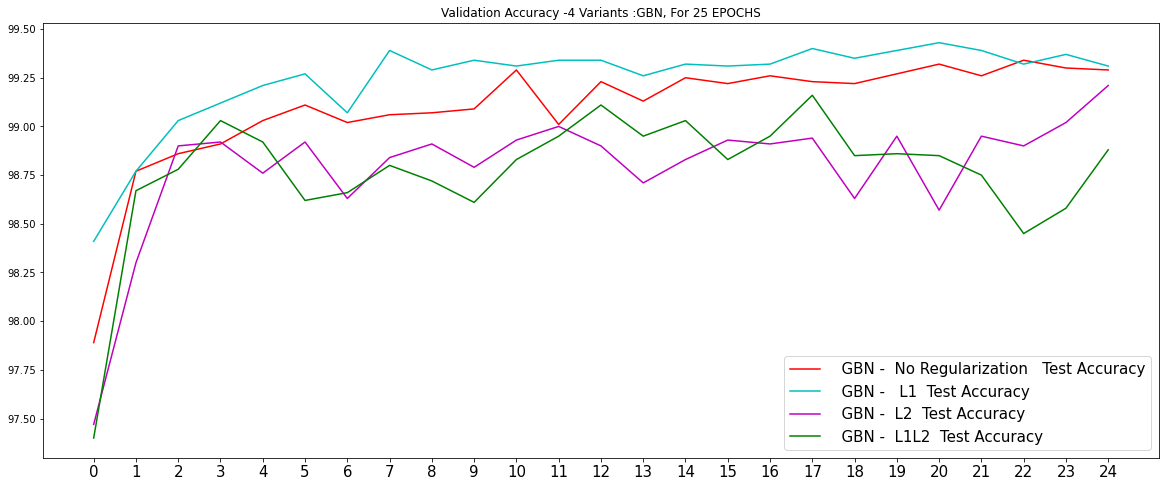

In [50]:
##Display Plot for: X-axis Epochs, Y-Axis Validation Accruacy
import matplotlib.pyplot as plt
plt.figure(1,figsize=(20,8))
plt.xticks(range(0,EPOCHS),fontsize=15)
plt.yticks(fontsize=10)

plt.plot(range(0,EPOCHS),Validation_Accuracy_GBN_NONE,'-r',label='  GBN -  No Regularization   Test Accuracy')
plt.plot(range(0,EPOCHS),Validation_Accuracy_GBN_L1,'-c',label='  GBN -   L1  Test Accuracy')
plt.plot(range(0,EPOCHS),Validation_Accuracy_GBN_L2,'-m',label='  GBN -  L2  Test Accuracy')
plt.plot(range(0,EPOCHS),Validation_Accuracy_GBN_L1L2,'-g',label='  GBN -  L1L2  Test Accuracy')
plt.legend(loc=0,fontsize=15)
plt.title("Validation Accuracy -4 Variants :GBN, For {} EPOCHS".format(EPOCHS))
plt.show()

ValueError: ignored

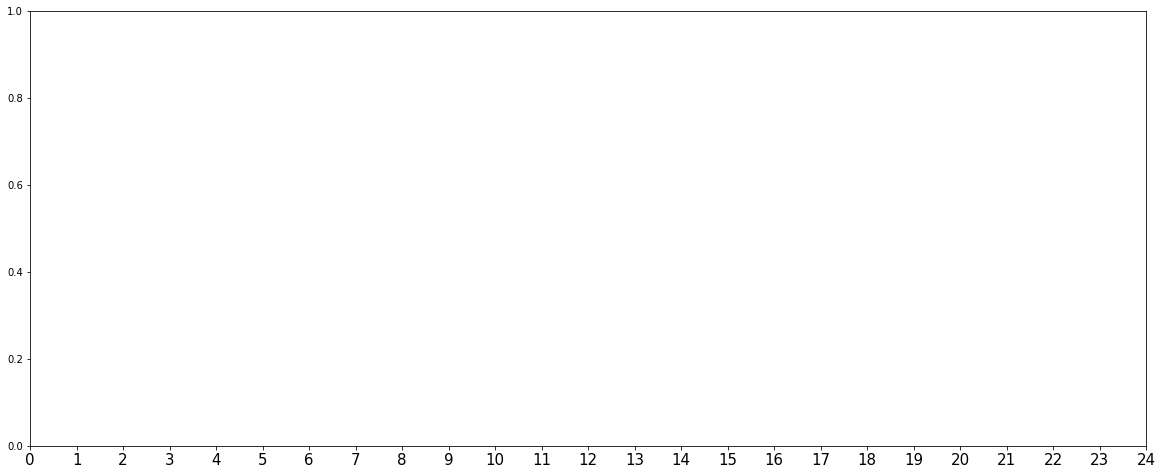

In [43]:
##Display Plot for: X-axis Epochs, Y-Axis Validation Accruacy
import matplotlib.pyplot as plt
plt.figure(1,figsize=(20,8))
plt.xticks(range(0,EPOCHS),fontsize=15)
plt.yticks(fontsize=10)
plt.plot(range(0,EPOCHS),Validation_Accuracy_BN_NONE,'-b',label=' BN - No Regularization  Test Accuracy')
plt.plot(range(0,EPOCHS),Validation_Accuracy_BN_L1,'-g',label='  BN - L1 Test Accuracy')
plt.plot(range(0,EPOCHS),Validation_Accuracy_BN_L2,'-r',label='  BN -  L2  Test Accuracy')
plt.plot(range(0,EPOCHS),Validation_Accuracy_BN_L1L2,'-y',label='  BN -  L1L2  Test Accuracy')
plt.plot(range(0,EPOCHS),Validation_Accuracy_GBN_NONE,'-r',label='  GBN -  No Regularization   Test Accuracy')
plt.plot(range(0,EPOCHS),Validation_Accuracy_GBN_L1,'-c',label='  GBN -   L1  Test Accuracy')
plt.plot(range(0,EPOCHS),Validation_Accuracy_GBN_L2,'-m',label='  GBN -  L2  Test Accuracy')
plt.plot(range(0,EPOCHS),Validation_Accuracy_GBN_L1L2,'-g',label='  GBN -  L1L2  Test Accuracy')

plt.legend(loc=0,fontsize=15)
plt.title("Validation Accuracy Loss -8 Variants, For {} EPOCHS".format(EPOCHS))
plt.show()

#Display Plot for: X-axis Epochs, Y-Axis Validation Loss

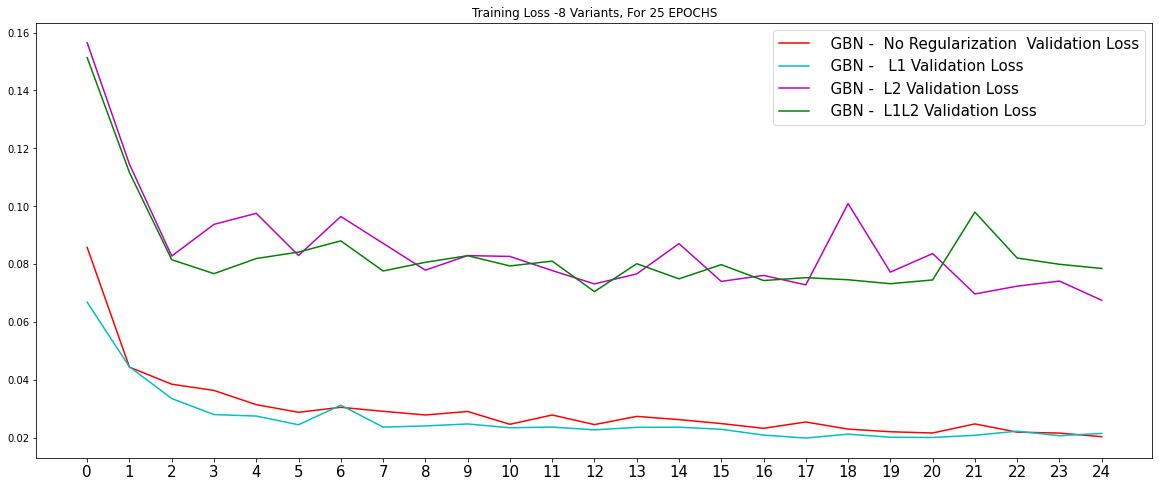

In [20]:

plt.figure(1,figsize=(20,8))
plt.xticks(range(0,EPOCHS),fontsize=15)
plt.yticks(fontsize=10)
#plt.plot(range(0,EPOCHS),Total_Test_loss_BN_NONE,'-b',label=' BN - No Regularization Validation Loss')
#plt.plot(range(0,EPOCHS),Total_Test_loss_BN_L1,'-g',label='  BN - L1 Validation Loss')
#plt.plot(range(0,EPOCHS),Total_Test_loss_BN_L2,'-r',label='  BN -  L2 Validation Loss')
#plt.plot(range(0,EPOCHS),Total_Test_loss_BN_L1L2,'-y',label='  BN -  L1L2 Validation Loss')
plt.plot(range(0,EPOCHS),Total_Test_loss_GBN_NONE,'-r',label='  GBN -  No Regularization  Validation Loss')
plt.plot(range(0,EPOCHS),Total_Test_loss_GBN_L1,'-c',label='  GBN -   L1 Validation Loss')
plt.plot(range(0,EPOCHS),Total_Test_loss_GBN_L2,'-m',label='  GBN -  L2 Validation Loss')
plt.plot(range(0,EPOCHS),Total_Test_loss_GBN_L1L2,'-g',label='  GBN -  L1L2 Validation Loss')

plt.legend(loc=0,fontsize=15)
plt.title("Training Loss -8 Variants, For {} EPOCHS".format(EPOCHS))
plt.show()


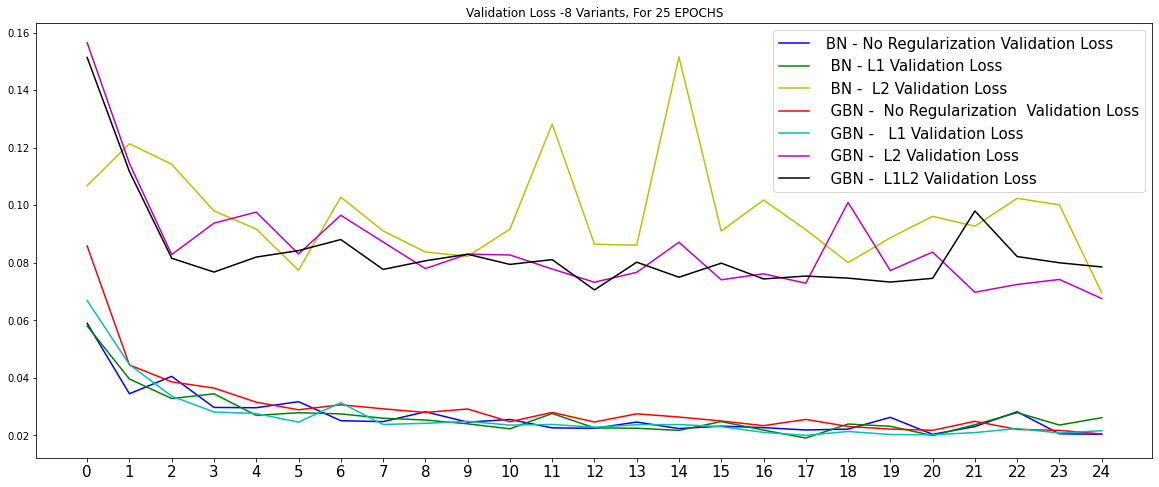

In [42]:
plt.figure(1,figsize=(20,8))
plt.xticks(range(0,EPOCHS),fontsize=15)
plt.yticks(fontsize=10)
plt.plot(range(0,EPOCHS),Total_Test_loss_BN_NONE,'-b',label=' BN - No Regularization Validation Loss')
plt.plot(range(0,EPOCHS),Total_Test_loss_BN_L1,'-g',label='  BN - L1 Validation Loss')
plt.plot(range(0,EPOCHS),Total_Test_loss_BN_L2,'-y',label='  BN -  L2 Validation Loss')
#plt.plot(range(0,EPOCHS),Total_Test_loss_BN_L1L2,'-y',label='  BN -  L1L2 Validation Loss')
plt.plot(range(0,EPOCHS),Total_Test_loss_GBN_NONE,'-r',label='  GBN -  No Regularization  Validation Loss')
plt.plot(range(0,EPOCHS),Total_Test_loss_GBN_L1,'-c',label='  GBN -   L1 Validation Loss')
plt.plot(range(0,EPOCHS),Total_Test_loss_GBN_L2,'-m',label='  GBN -  L2 Validation Loss')
plt.plot(range(0,EPOCHS),Total_Test_loss_GBN_L1L2,'-k',label='  GBN -  L1L2 Validation Loss')

plt.legend(loc=0,fontsize=15)
plt.title("Validation Loss -8 Variants, For {} EPOCHS".format(EPOCHS))
plt.show()


#Display Plot for: X-axis Epochs, Y-Axis Training Loss

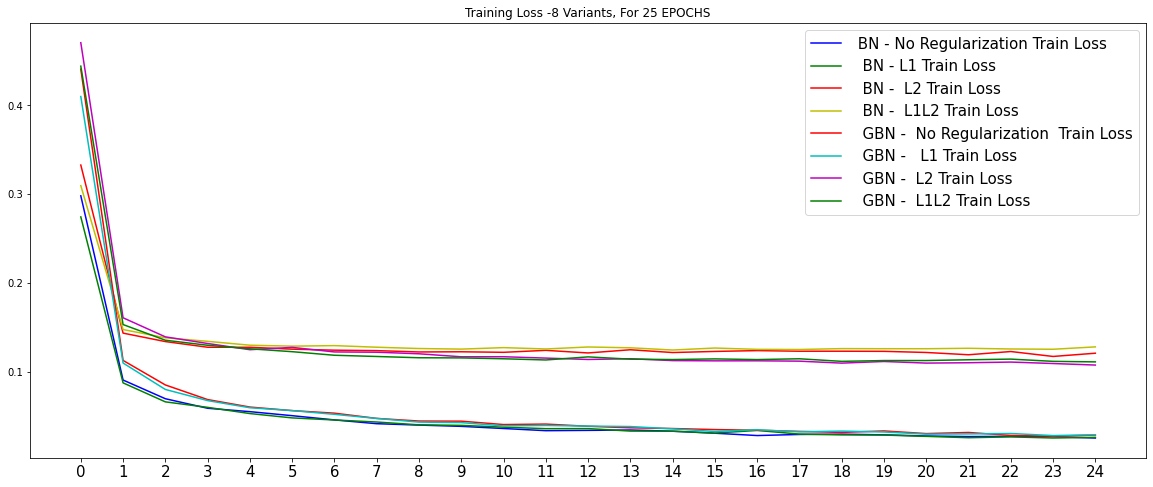

In [31]:

plt.figure(1,figsize=(20,8))
plt.xticks(range(0,EPOCHS),fontsize=15)
plt.yticks(fontsize=10)
plt.plot(range(0,EPOCHS),Total_train_loss_BN_NONE,'-b',label=' BN - No Regularization Train Loss')
plt.plot(range(0,EPOCHS),Total_train_loss_BN_L1,'-g',label='  BN - L1 Train Loss')
plt.plot(range(0,EPOCHS),Total_train_loss_BN_L2,'-r',label='  BN -  L2 Train Loss')
plt.plot(range(0,EPOCHS),Total_train_loss_BN_L1L2,'-y',label='  BN -  L1L2 Train Loss')
plt.plot(range(0,EPOCHS),Total_train_loss_GBN_NONE,'-r',label='  GBN -  No Regularization  Train Loss')
plt.plot(range(0,EPOCHS),Total_train_loss_GBN_L1,'-c',label='  GBN -   L1 Train Loss')
plt.plot(range(0,EPOCHS),Total_train_loss_GBN_L2,'-m',label='  GBN -  L2 Train Loss')
plt.plot(range(0,EPOCHS),Total_train_loss_GBN_L1L2,'-g',label='  GBN -  L1L2 Train Loss')

plt.legend(loc=0,fontsize=15)
plt.title("Training Loss -8 Variants, For {} EPOCHS".format(EPOCHS))
plt.show()


## Consider Two cases BN & GBN: For both type of Normalizations, consider cases without Regularization and display 25 images out of these sets

In [0]:
def plot_Misclassified_Images(misclassifiedImages):
  fig = plt.figure(figsize=(12,12))
  for i in range(25):
    sub = fig.add_subplot(5, 5, i+1)
    plt.imshow(misclassifiedImages[i][0].cpu().numpy().squeeze(),cmap='gray',interpolation='none')
    sub.set_title("Pred={}, Act={}".format(str(misclassifiedImages[i][1].data.cpu().numpy()),str(misclassifiedImages[i][2].data.cpu().numpy())))
  plt.tight_layout()
  plt.show()
  


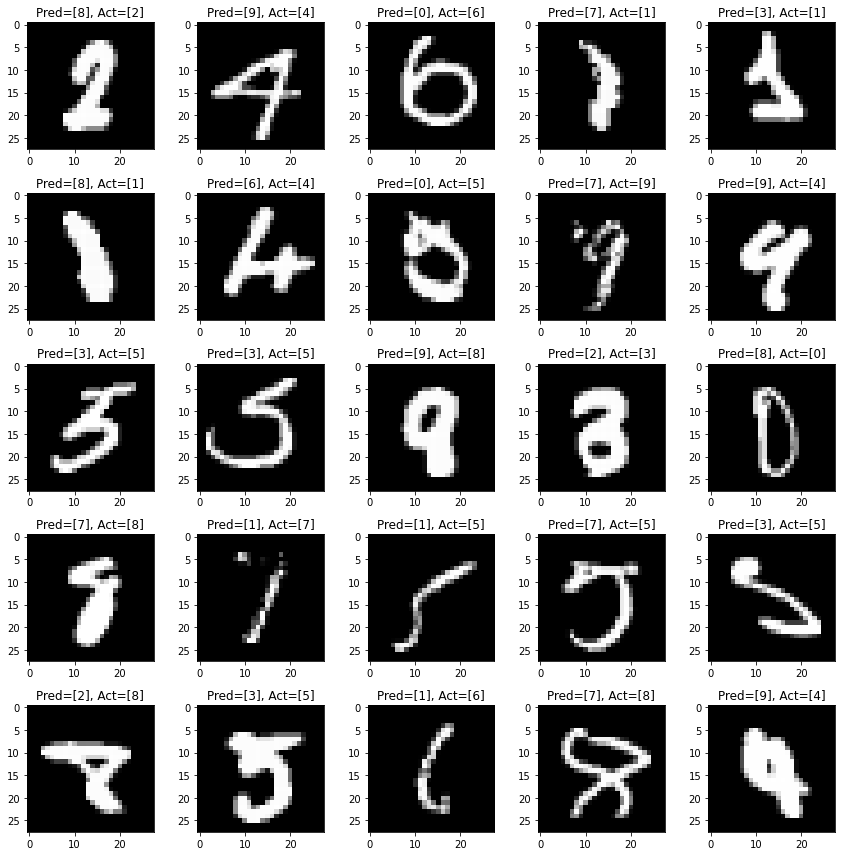

IndexError: ignored

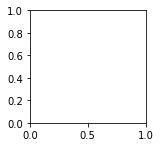

In [0]:
plot_Misclassified_Images(Misclassfication_false_images_BN) # BN without L1/L2


In [47]:

print(Misclassfication_false_images_BN)

[]


#Goal	
In this iteration we intend to compare the Regularization methods along with Batch and Ghost Normalization. And analyze their impact on Model accuracy.
#Params	
9,923

#WITH 15 EPOCHS

#DropOut value
0.05

#Best Train Accuracy	
99.33%

#Best Test Accuracy	
99.4%

#Observation/ Analysis/Conclusion	
With Batch Normalization the training time is longer than with Ghost Batch Normalization


##Notes:
With L2 Regualrization: The Avg Validation Loss is increased and overall Validation accuracy is decreased.

With Batch Norm and Ghost Batch Norm, the validation loss fluctuates with L2 regularization


With GBN:
 L1 Regualrization causes faster drop in validation Loss
 Without Regualrization methods, the validation is accuracy is not fluctuating.

 With BN:
 validation accuracy remains constant even with number of Epochs increasing,validation accuracy increases and then becomes constistent with Epochs increasing.


#Model Health:
Even though the overall Model accuracy has come down, the model is still great, as there is NO OVERFITTING.